 1. Librerías y Configuración Inicial


In [46]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


2. Carga de Datos y Exploración Preliminar

In [47]:
users = pd.read_csv("Final_Updated_Expanded_Users.csv")
destinations = pd.read_csv("Expanded_Destinations.csv")
history = pd.read_csv("Final_Updated_Expanded_UserHistory.csv")
reviews = pd.read_csv("Final_Updated_Expanded_Reviews.csv")

print(f"Usuarios: {users.shape}")
print(f"Destinos: {destinations.shape}")
print(f"Historial: {history.shape}")
print(f"Reviews: {reviews.shape}")

# Valores únicos

print(f"  - En Users: {users['UserID'].nunique()}")
print(f"  - En History: {history['UserID'].nunique()}")
print(f"  - En Reviews: {reviews['UserID'].nunique()}")

print(f"  - En Destinations: {destinations['DestinationID'].nunique()}")
print(f"  - En History: {history['DestinationID'].nunique()}")
print(f"  - En Reviews: {reviews['DestinationID'].nunique()}")

# Revisión de valores nulos
print("Users:", users.isnull().sum().to_dict())
print("History:", history.isnull().sum().to_dict())
print("Reviews:", reviews.isnull().sum().to_dict())
print("Destinations:", destinations.isnull().sum().to_dict())

# Revisión de duplicados
print(f"  - Users: {users.duplicated().sum()}")
print(f"  - History: {history.duplicated().sum()}")
print(f"  - Reviews: {reviews.duplicated().sum()}")
print(f"  - Destinations: {destinations.duplicated().sum()}")

Usuarios: (999, 7)
Destinos: (1000, 6)
Historial: (999, 5)
Reviews: (999, 5)
  - En Users: 999
  - En History: 642
  - En Reviews: 624
  - En Destinations: 1000
  - En History: 638
  - En Reviews: 651
Users: {'UserID': 0, 'Name': 0, 'Email': 0, 'Preferences': 0, 'Gender': 0, 'NumberOfAdults': 0, 'NumberOfChildren': 0}
History: {'HistoryID': 0, 'UserID': 0, 'DestinationID': 0, 'VisitDate': 0, 'ExperienceRating': 0}
Reviews: {'ReviewID': 0, 'DestinationID': 0, 'UserID': 0, 'Rating': 0, 'ReviewText': 0}
Destinations: {'DestinationID': 0, 'Name': 0, 'State': 0, 'Type': 0, 'Popularity': 0, 'BestTimeToVisit': 0}
  - Users: 0
  - History: 0
  - Reviews: 0
  - Destinations: 0


 3. Unión de Datasets (Merge)

In [57]:
# Renombrar columnas para evitar conflictos
users_renamed = users.rename(columns={'Name': 'UserName'})
destinations_renamed = destinations.rename(columns={'Name': 'DestinationName'})

# Filtrar usuarios y destinos activos (con historial)
active_users = history['UserID'].unique()
active_destinations = history['DestinationID'].unique()

users_filtered = users_renamed[users_renamed['UserID'].isin(active_users)].copy()
destinations_filtered = destinations_renamed[destinations_renamed['DestinationID'].isin(active_destinations)].copy()

# Merge secuencial
data = history.merge(users_filtered, on='UserID', how='left')
data = data.merge(destinations_filtered, on='DestinationID', how='left')

# Agregar rating promedio por usuario-destino desde reviews
reviews_avg = reviews.groupby(['UserID', 'DestinationID'])['Rating'].mean().reset_index()
reviews_avg.rename(columns={'Rating': 'AvgReviewRating'}, inplace=True)
data = data.merge(reviews_avg, on=['UserID', 'DestinationID'], how='left')

In [59]:
# ============================
# 2. LIMPIEZA DE OUTLIERS
# ============================

# Revisar rangos
print("ExperienceRating:", data['ExperienceRating'].min(), "a", data['ExperienceRating'].max())
print("AvgReviewRating:", data['AvgReviewRating'].min(), "a", data['AvgReviewRating'].max())

# Asumimos que el rango válido es 1 a 5
data = data[(data['ExperienceRating'] >= 1) & (data['ExperienceRating'] <= 5)]
data['AvgReviewRating'].fillna(data['AvgReviewRating'].mean(), inplace=True)

# ============================
# 3. MATRIZ USUARIO-DESTINO
# ============================

user_item_matrix = data.pivot_table(
    index='UserID',
    columns='DestinationID',
    values='ExperienceRating',
    aggfunc='mean'
).fillna(0)

# Sparsity
non_zero_count = (user_item_matrix > 0).sum().sum()
sparsity = 1 - (non_zero_count / (user_item_matrix.shape[0] * user_item_matrix.shape[1]))
print(f"Sparsity: {sparsity:.2%}")

# ============================
# 4. CONTENIDO DE DESTINOS
# ============================

# One-hot encoding para categorías
categorical_cols = ['Type', 'State', 'BestTimeToVisit']
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(destinations_filtered[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols), index=destinations_filtered.index)

# Escalar popularidad
scaler = StandardScaler()
popularity_scaled = scaler.fit_transform(destinations_filtered[['Popularity']])
popularity_df = pd.DataFrame(popularity_scaled, columns=['Popularity_scaled'], index=destinations_filtered.index)

# Combinar características
content_features = pd.concat([encoded_df, popularity_df], axis=1)
content_features['DestinationID'] = destinations_filtered['DestinationID'].values

# ============================
# 5. PERFIL DE USUARIOS
# ============================

# TF-IDF sobre Preferences
tfidf = TfidfVectorizer(stop_words='english', max_features=50)
user_pref_matrix = tfidf.fit_transform(users_filtered['Preferences'].fillna(''))
user_pref_df = pd.DataFrame(user_pref_matrix.toarray(), index=users_filtered['UserID'], columns=tfidf.get_feature_names_out())

# Codificar género y escalar demográficos
demographic = users_filtered[['UserID', 'Gender', 'NumberOfAdults', 'NumberOfChildren']].copy()
demographic = pd.get_dummies(demographic, columns=['Gender'], drop_first=True)
demo_scaled = scaler.fit_transform(demographic[['NumberOfAdults', 'NumberOfChildren']])
demo_scaled_df = pd.DataFrame(demo_scaled, columns=['Adults_scaled', 'Children_scaled'], index=demographic.index)
demographic_final = pd.concat([demographic[['UserID']].reset_index(drop=True), demo_scaled_df, demographic.drop(['UserID', 'NumberOfAdults', 'NumberOfChildren'], axis=1).reset_index(drop=True)], axis=1)

# Combinar perfil completo del usuario
# Aseguramos que ambos DataFrames tengan UserID como índice y sean únicos
user_pref_df_unique = user_pref_df[~user_pref_df.index.duplicated(keep='first')]
demographic_final_unique = demographic_final.drop_duplicates(subset='UserID').set_index('UserID')

user_profile = user_pref_df_unique.join(demographic_final_unique, how='inner')

# ============================
# 6. ESCALAR RATINGS
# ============================

rating_scaler = StandardScaler()
data[['ExperienceRating_scaled', 'AvgReviewRating_scaled']] = rating_scaler.fit_transform(data[['ExperienceRating', 'AvgReviewRating']])


ExperienceRating: 1 a 5
AvgReviewRating: nan a nan
Sparsity: 99.76%


In [62]:
# ============================
# SIMILITUD Y CLUSTERING DE DESTINOS
# ============================

# Matriz de similitud entre destinos
content_matrix = content_features.drop('DestinationID', axis=1)
content_similarity_matrix = cosine_similarity(content_matrix)

similarity_df = pd.DataFrame(
    content_similarity_matrix,
    index=content_features['DestinationID'],
    columns=content_features['DestinationID']
)

print("Matriz de similitud entre destinos generada.")

# Clustering de destinos
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='k-means++')
clusters = kmeans.fit_predict(content_matrix)

# Asignar clusters solo a los destinos activos
destinations_filtered['Cluster'] = clusters
print("Se asignaron clústeres a los destinos activos.")

# Mostrar ejemplos de cada clúster
for cluster_id in range(k):
    print(f"\n--- Cluster {cluster_id} ---")
    sample = destinations_filtered[destinations_filtered['Cluster'] == cluster_id][['DestinationName', 'Type', 'State']].head(3)
    print(sample.to_string(index=False))

Matriz de similitud entre destinos generada.
Se asignaron clústeres a los destinos activos.

--- Cluster 0 ---
DestinationName       Type         State
      Taj Mahal Historical Uttar Pradesh
      Taj Mahal Historical Uttar Pradesh
      Taj Mahal Historical Uttar Pradesh

--- Cluster 1 ---
DestinationName      Type             State
     Leh Ladakh Adventure Jammu and Kashmir
     Leh Ladakh Adventure Jammu and Kashmir
     Leh Ladakh Adventure Jammu and Kashmir

--- Cluster 2 ---
DestinationName Type     State
    Jaipur City City Rajasthan
    Jaipur City City Rajasthan
    Jaipur City City Rajasthan

--- Cluster 3 ---
  DestinationName   Type  State
Kerala Backwaters Nature Kerala
Kerala Backwaters Nature Kerala
Kerala Backwaters Nature Kerala

--- Cluster 4 ---
DestinationName  Type State
    Goa Beaches Beach   Goa
    Goa Beaches Beach   Goa
    Goa Beaches Beach   Goa

--- Cluster 5 ---
  DestinationName   Type  State
Kerala Backwaters Nature Kerala
Kerala Backwaters Nature K

In [63]:
# ============================
# 3. SISTEMA DE RECOMENDACIÓN HÍBRIDO
# ============================

class HybridRecommendationSystem:
    def __init__(self):
        self.user_item_matrix = None
        self.content_features = None
        self.user_similarity = None
        self.item_similarity = None
        self.content_similarity = None
        self.destinations = None
        self.users = None
        self.dynamic_threshold = 4.0  # Valor por defecto
    
    def fit(self, user_item_matrix, content_features, destinations, users):
        self.user_item_matrix = user_item_matrix
        self.content_features = content_features
        self.destinations = destinations
        self.users = users
        
        # Calcular threshold dinámico basado en la distribución real
        # Solo considerar ratings positivos (mayores que 0)
        non_zero_ratings = user_item_matrix.values[user_item_matrix.values > 0]
        
        if len(non_zero_ratings) > 0:
            self.dynamic_threshold = np.percentile(non_zero_ratings, 75)  # Percentil 75
        else:
            self.dynamic_threshold = 4.0  # Valor por defecto si no hay ratings
            
        print(f"Threshold dinámico calculado: {self.dynamic_threshold:.2f}")
        print(f"Ratings no cero: {len(non_zero_ratings)}")

        print("Calculando similitudes...")

        # Similitud entre usuarios (considerando solo valores positivos)
        user_matrix = user_item_matrix.copy()
        # Reemplazar 0 con NaN para ignorarlos en el cálculo de similitud
        user_matrix[user_matrix == 0] = np.nan
        user_matrix = user_matrix.fillna(0)
        
        self.user_similarity = cosine_similarity(user_matrix)
        self.user_similarity = pd.DataFrame(
            self.user_similarity,
            index=user_item_matrix.index,
            columns=user_item_matrix.index
        )

        # Similitud entre items
        item_matrix = user_item_matrix.T
        self.item_similarity = cosine_similarity(item_matrix)
        self.item_similarity = pd.DataFrame(
            self.item_similarity,
            index=user_item_matrix.columns,
            columns=user_item_matrix.columns
        )

        # Similitud basada en contenido
        content_matrix = content_features.drop('DestinationID', axis=1)
        self.content_similarity = cosine_similarity(content_matrix)
        self.content_similarity = pd.DataFrame(
            self.content_similarity,
            index=content_features['DestinationID'],
            columns=content_features['DestinationID']
        )

        print("Sistema entrenado correctamente!")
    
    def get_popular_destinations(self, n=5):
        """Devuelve los destinos más populares como fallback"""
        return self.destinations.sort_values('Popularity', ascending=False).head(n)
    
    def collaborative_filtering_prediction(self, user_id, destination_id, method='user_based'):
        try:
            if method == 'user_based':
                # Obtener usuarios similares (excluyendo al propio usuario)
                similar_users = self.user_similarity.loc[user_id].sort_values(ascending=False)
                similar_users = similar_users[similar_users.index != user_id].head(10)
                
                if similar_users.empty:
                    return self.user_item_matrix.loc[:, destination_id].mean()
                
                numerator = 0
                denominator = 0
                for similar_user, similarity in similar_users.items():
                    rating = self.user_item_matrix.loc[similar_user, destination_id]
                    # Solo considerar ratings positivos
                    if rating > 0:
                        numerator += similarity * rating
                        denominator += abs(similarity)
                
                if denominator == 0:
                    return self.user_item_matrix.loc[:, destination_id].mean()
                
                return numerator / denominator
            
            else:  # item-based
                user_ratings = self.user_item_matrix.loc[user_id]
                rated_items = user_ratings[user_ratings > 0].index
                
                if len(rated_items) == 0:
                    return self.user_item_matrix.loc[:, destination_id].mean()
                
                numerator = 0
                denominator = 0
                for item in rated_items:
                    similarity = self.item_similarity.loc[item, destination_id]
                    rating = user_ratings[item]
                    numerator += similarity * rating
                    denominator += abs(similarity)
                
                if denominator == 0:
                    return user_ratings.mean()
                
                return numerator / denominator
                
        except Exception as e:
            print(f"Error en CF: {e}")
            return 3.0

    def content_based_prediction(self, user_id, destination_id):
        try:
            user_ratings = self.user_item_matrix.loc[user_id]
            visited_destinations = user_ratings[user_ratings > 0]
            
            if len(visited_destinations) == 0:
                return self.user_item_matrix.loc[:, destination_id].mean()
            
            similarities = []
            ratings = []
            
            for visited_dest, rating in visited_destinations.items():
                try:
                    sim = self.content_similarity.loc[visited_dest, destination_id]
                    similarities.append(sim)
                    ratings.append(rating)
                except:
                    continue
            
            if len(similarities) == 0 or np.sum(similarities) == 0:
                return self.user_item_matrix.loc[:, destination_id].mean()
            
            weighted_rating = np.average(ratings, weights=similarities)
            return weighted_rating
            
        except Exception as e:
            print(f"Error en CB: {e}")
            return 3.0

    def hybrid_prediction(self, user_id, destination_id, collaborative_weight=0.3, content_weight=0.7):
        try:
            collab_pred = self.collaborative_filtering_prediction(user_id, destination_id, 'user_based')
            content_pred = self.content_based_prediction(user_id, destination_id)
            
            # Si no hay suficiente información, usar un promedio ponderado
            if collab_pred == 0 or content_pred == 0:
                return max(collab_pred, content_pred)
                
            hybrid_pred = collaborative_weight * collab_pred + content_weight * content_pred
            return np.clip(hybrid_pred, 1, 5)
        except:
            return 3.5

    def recommend_destinations(self, user_id, n_recommendations=5, exclude_visited=True):
        if user_id not in self.user_item_matrix.index:
            print(f"Usuario {user_id} no encontrado. Devolviendo destinos populares.")
            return self.get_popular_destinations(n_recommendations)[['DestinationID', 'DestinationName', 'State', 'Type', 'Popularity', 'Cluster']]
        
        user_ratings = self.user_item_matrix.loc[user_id]
        
        #Asegurar que siempre filtramos visitados
        if exclude_visited:
            unvisited_destinations = user_ratings[user_ratings == 0].index
        else:
            unvisited_destinations = user_ratings.index
        
        # Si no hay destinos sin visitar, devolver populares
        if len(unvisited_destinations) == 0:
            print(f"Usuario {user_id} ha visitado todos los destinos. Devolviendo populares.")
            return self.get_popular_destinations(n_recommendations)[['DestinationID', 'DestinationName', 'State', 'Type', 'Popularity', 'Cluster']]
        
        predictions = []
        for dest_id in unvisited_destinations:
            pred_rating = self.hybrid_prediction(user_id, dest_id)
            predictions.append({
                'DestinationID': dest_id,
                'PredictedRating': pred_rating
            })
        
        recommendations_df = pd.DataFrame(predictions)
        recommendations_df = recommendations_df.sort_values('PredictedRating', ascending=False)
        
        # Merge con información de destinos
        recommendations_df = recommendations_df.merge(
            self.destinations[['DestinationID', 'DestinationName', 'State', 'Type', 'Popularity', 'BestTimeToVisit', 'Cluster']],
            on='DestinationID',
            how='left'
        )
        
        #  Quitar duplicados por nombre de destino
        recommendations_df = recommendations_df.drop_duplicates(subset=['DestinationName'])
        
        #  Mejorar diversidad con cluster awareness
        # Identificar clusters de destinos bien evaluados por el usuario
        visited_destinations = user_ratings[user_ratings > 0]
        if len(visited_destinations) > 0:
            visited_dest_ids = visited_destinations.index
            user_clusters = self.destinations[
                self.destinations['DestinationID'].isin(visited_dest_ids)
            ]['Cluster'].value_counts()
            
            if len(user_clusters) > 0:
                top_clusters = user_clusters.index[:3]  # Top 3 clusters preferidos
                
                # Priorizar destinos de clusters preferidos
                recommendations_df['ClusterPriority'] = recommendations_df['Cluster'].apply(
                    lambda x: 1 if x in top_clusters else 0
                )
                
                # Ordenar por prioridad de cluster y luego por rating predicho
                recommendations_df = recommendations_df.sort_values(
                    ['ClusterPriority', 'PredictedRating'], 
                    ascending=[False, False]
                )
        
        return recommendations_df.head(n_recommendations)

In [66]:
# ============================
# 4. ENTRENAMIENTO DEL SISTEMA
# ============================


# Entrenamiento del sistema usando los datasets renombrados
recommender = HybridRecommendationSystem()
recommender.fit(user_item_matrix, content_features, destinations_filtered, users_filtered)



Threshold dinámico calculado: 4.00
Ratings no cero: 999
Calculando similitudes...
Sistema entrenado correctamente!


In [67]:
# ============================
# 5. EVALUACIÓN DEL SISTEMA 
# ============================

def evaluate_recommendations(recommender, user_item_matrix, k=10, use_dynamic_threshold=True):
    """Evaluar el sistema de recomendación con métricas de ranking mejoradas"""
    
    # Usar threshold dinámico
    if use_dynamic_threshold:
        threshold = recommender.dynamic_threshold
    else:
        threshold = 4.0
    
    print(f"Usando threshold: {threshold:.2f}")
    
    # Crear conjunto de evaluación
    all_users = list(user_item_matrix.index)
    evaluation_users = np.random.choice(all_users, size=min(200, len(all_users)), replace=False)
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    ndcg_scores = []
    diversity_scores = []
    
    for user_id in evaluation_users:
        # Obtener items relevantes (rating >= threshold)
        user_ratings = user_item_matrix.loc[user_id]
        relevant_items = set(user_ratings[user_ratings >= threshold].index)
        
        if len(relevant_items) == 0:
            continue
            
        # Generar recomendaciones
        recommendations = recommender.recommend_destinations(user_id, n_recommendations=k, exclude_visited=False)
        
        if recommendations.empty:
            continue
            
        recommended_items = set(recommendations['DestinationID'].tolist())
        
        # Calcular métricas
        true_positives = len(relevant_items.intersection(recommended_items))
        
        # Precision@K
        precision = true_positives / len(recommended_items) if len(recommended_items) > 0 else 0
        precision_scores.append(precision)
        
        # Recall@K  
        recall = true_positives / len(relevant_items) if len(relevant_items) > 0 else 0
        recall_scores.append(recall)
        
        # F1-Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
        
        # MEJORA: Diversidad por clusters
        unique_clusters = recommendations['Cluster'].nunique()
        total_clusters = recommender.destinations['Cluster'].nunique()
        diversity = unique_clusters / min(total_clusters, k)
        diversity_scores.append(diversity)
        
        # NDCG@K (Normalized Discounted Cumulative Gain)
        dcg = 0
        idcg = 0
        
        # DCG
        for i, item_id in enumerate(recommendations['DestinationID'].tolist()):
            if item_id in relevant_items:
                relevance = user_ratings[item_id] if item_id in user_ratings.index else 0
                dcg += relevance / np.log2(i + 2)
        
        # IDCG (ideal DCG)
        sorted_relevances = sorted([user_ratings[item] for item in relevant_items if item in user_ratings.index], reverse=True)
        for i, relevance in enumerate(sorted_relevances[:k]):
            idcg += relevance / np.log2(i + 2)
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)
    
    return {
        'Precision@K': np.mean(precision_scores) if precision_scores else 0,
        'Recall@K': np.mean(recall_scores) if recall_scores else 0,
        'F1-Score@K': np.mean(f1_scores) if f1_scores else 0,
        'NDCG@K': np.mean(ndcg_scores) if ndcg_scores else 0,
        'Diversity@K': np.mean(diversity_scores) if diversity_scores else 0,
        'Users_Evaluated': len(evaluation_users),
        'K': k,
        'Threshold': threshold
    }

# Evaluar el sistema mejorado
metrics = evaluate_recommendations(recommender, user_item_matrix, k=10, use_dynamic_threshold=True)
print("MÉTRICAS del Sistema de Recomendación:")
print(f"Precision@{metrics['K']}: {metrics['Precision@K']:.4f}")
print(f"Recall@{metrics['K']}: {metrics['Recall@K']:.4f}")
print(f"F1-Score@{metrics['K']}: {metrics['F1-Score@K']:.4f}")
print(f"NDCG@{metrics['K']}: {metrics['NDCG@K']:.4f}")
print(f"Diversity@{metrics['K']}: {metrics['Diversity@K']:.4f}")
print(f"Usuarios evaluados: {metrics['Users_Evaluated']}")
print(f"Threshold dinámico: {metrics['Threshold']:.2f}")

# Comparar con threshold fijo
print("\n=== COMPARACIÓN: Threshold Dinámico vs Fijo ===")
metrics_fixed = evaluate_recommendations(recommender, user_item_matrix, k=10, use_dynamic_threshold=False)
print("Threshold Fijo (4.0):")
print(f"Precision: {metrics_fixed['Precision@K']:.4f} | Recall: {metrics_fixed['Recall@K']:.4f} | F1: {metrics_fixed['F1-Score@K']:.4f}")
print(f"Threshold Dinámico ({metrics['Threshold']:.2f}):")
print(f"Precision: {metrics['Precision@K']:.4f} | Recall: {metrics['Recall@K']:.4f} | F1: {metrics['F1-Score@K']:.4f}")

# Evaluar con diferentes valores de K
print("\nEvaluación con diferentes valores de K:")
for k_val in [5, 10, 20]:
    k_metrics = evaluate_recommendations(recommender, user_item_matrix, k=k_val, use_dynamic_threshold=True)
    print(f"K={k_val}: Precision={k_metrics['Precision@K']:.3f}, Recall={k_metrics['Recall@K']:.3f}, F1={k_metrics['F1-Score@K']:.3f}, Diversity={k_metrics['Diversity@K']:.3f}")

Usando threshold: 4.00
MÉTRICAS del Sistema de Recomendación:
Precision@10: 0.0731
Recall@10: 0.3280
F1-Score@10: 0.1183
NDCG@10: 0.3297
Diversity@10: 0.8333
Usuarios evaluados: 200
Threshold dinámico: 4.00

=== COMPARACIÓN: Threshold Dinámico vs Fijo ===
Usando threshold: 4.00
Threshold Fijo (4.0):
Precision: 0.0674 | Recall: 0.2959 | F1: 0.1082
Threshold Dinámico (4.00):
Precision: 0.0731 | Recall: 0.3280 | F1: 0.1183

Evaluación con diferentes valores de K:
Usando threshold: 4.00
K=5: Precision=0.085, Recall=0.360, F1=0.135, Diversity=1.000
Usando threshold: 4.00
K=10: Precision=0.067, Recall=0.297, F1=0.108, Diversity=0.833
Usando threshold: 4.00
K=20: Precision=0.076, Recall=0.288, F1=0.117, Diversity=0.833


In [69]:
# ============================
# 6. EJEMPLOS DE RECOMENDACIONES 
# ============================


# Seleccionar algunos usuarios para mostrar recomendaciones
sample_users = user_item_matrix.index[:5]

for user_id in sample_users:
    print(f"\n--- Recomendaciones para Usuario {user_id} ---")
    
    # Obtener información del usuario
    user_info = users_renamed[users_renamed['UserID'] == user_id].iloc[0]
    print(f"Perfil: {user_info['UserName']}, {user_info['Gender']}, Preferencias: {user_info['Preferences']}")
    print(f"Adultos: {user_info['NumberOfAdults']}, Niños: {user_info['NumberOfChildren']}")
    
    # Mostrar destinos visitados
    visited = user_item_matrix.loc[user_id]
    visited_destinations = visited[visited > 0]
    print(f"Destinos visitados ({len(visited_destinations)}):")
    for dest_id, rating in visited_destinations.head(3).items():
        dest_info = destinations_filtered[destinations_filtered['DestinationID'] == dest_id].iloc[0]
        print(f"  - {dest_info['DestinationName']} (Rating: {rating}, Tipo: {dest_info['Type']}, Cluster: {dest_info['Cluster']})")
    
    # Generar recomendaciones mejoradas
    recommendations = recommender.recommend_destinations(user_id, n_recommendations=5)
    
    if not recommendations.empty:
        print("Top 5 Recomendaciones MEJORADAS:")
        for idx, row in recommendations.iterrows():
            cluster_priority = "" if 'ClusterPriority' in row and row['ClusterPriority'] == 1 else ""
            print(f"  {idx+1}. {row['DestinationName']} ({row['State']}) {cluster_priority}")
            print(f"      Tipo: {row['Type']}, Cluster: {row['Cluster']}")
            print(f"      Rating Predicho: {row['PredictedRating']:.2f}, Popularidad: {row['Popularity']:.2f}")
        
        # Mostrar diversidad
        unique_clusters = recommendations['Cluster'].nunique()
        print(f"       Diversidad: {unique_clusters} clusters diferentes")
    else:
        print("No se pudieron generar recomendaciones para este usuario.")
    
    print("-" * 60)


--- Recomendaciones para Usuario 1 ---
Perfil: Kavya, Female, Preferencias: Beaches, Historical
Adultos: 1, Niños: 0
Destinos visitados (2):
  - Goa Beaches (Rating: 3.0, Tipo: Beach, Cluster: 4)
  - Taj Mahal (Rating: 5.0, Tipo: Historical, Cluster: 0)
Top 5 Recomendaciones MEJORADAS:
  1. Taj Mahal (Uttar Pradesh) 
      Tipo: Historical, Cluster: 0
      Rating Predicho: 4.38, Popularidad: 9.46
  132. Goa Beaches (Goa) 
      Tipo: Beach, Cluster: 4
      Rating Predicho: 2.42, Popularidad: 9.50
  255. Leh Ladakh (Jammu and Kashmir) 
      Tipo: Adventure, Cluster: 1
      Rating Predicho: 1.52, Popularidad: 8.41
  256. Jaipur City (Rajasthan) 
      Tipo: City, Cluster: 2
      Rating Predicho: 1.52, Popularidad: 9.16
  263. Kerala Backwaters (Kerala) 
      Tipo: Nature, Cluster: 5
      Rating Predicho: 1.52, Popularidad: 9.41
       Diversidad: 5 clusters diferentes
------------------------------------------------------------

--- Recomendaciones para Usuario 2 ---
Perfil: Roha

In [71]:
# ============================
# 7. ANÁLISIS DE EFECTIVIDAD
# ============================


# Análisis por tipo de destino
destination_analysis = data.groupby('Type').agg({
    'ExperienceRating': ['mean', 'count'],
    'Popularity': 'mean'
}).round(2)

print("Análisis por Tipo de Destino:")
print(destination_analysis)

# Análisis por cluster
cluster_analysis = destinations_filtered.groupby('Cluster').agg({
    'Popularity': 'mean',
    'Type': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'N/A',
    'DestinationID': 'count'
}).rename(columns={'DestinationID': 'Count'}).round(2)

print("\nAnálisis por Cluster:")
print(cluster_analysis)

# Análisis por género
gender_analysis = data.groupby('Gender').agg({
    'ExperienceRating': ['mean', 'count'],
    'Type': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'N/A'
}).round(2)

print("\nAnálisis por Género:")
print(gender_analysis)

#Análisis de satisfacción con threshold dinámico
if recommender.dynamic_threshold > 0:
    high_satisfaction_dynamic = (data['ExperienceRating'] >= recommender.dynamic_threshold).sum()
    high_satisfaction_fixed = (data['ExperienceRating'] >= 4).sum()
    total_ratings = len(data)
    satisfaction_rate_dynamic = high_satisfaction_dynamic / total_ratings * 100
    satisfaction_rate_fixed = high_satisfaction_fixed / total_ratings * 100

    print(f"\n ANÁLISIS DE SATISFACCIÓN MEJORADO:")
    print(f"Tasa de Satisfacción (Threshold Fijo >=4): {satisfaction_rate_fixed:.1f}%")
    print(f"Tasa de Satisfacción (Threshold Dinámico >={recommender.dynamic_threshold:.2f}): {satisfaction_rate_dynamic:.1f}%")
    print(f"Total de experiencias analizadas: {total_ratings}")

# Destinos más populares vs mejor calificados
top_destinations = data.groupby(['DestinationID', 'DestinationName']).agg({
    'ExperienceRating': 'mean',
    'Popularity': 'mean'
}).sort_values('ExperienceRating', ascending=False).head(10)

print("\nTop 10 Destinos Mejor Calificados:")
print(top_destinations)


Análisis por Tipo de Destino:
           ExperienceRating       Popularity
                       mean count       mean
Type                                        
Adventure              2.99   204       8.46
Beach                  2.94   190       8.53
City                   2.81   185       8.58
Historical             3.01   209       8.55
Nature                 2.78   211       8.56

Análisis por Cluster:
         Popularity        Type  Count
Cluster                               
0              8.53  Historical    132
1              8.47   Adventure    130
2              8.57        City    120
3              8.02      Nature     68
4              8.50       Beach    124
5              9.02      Nature     64

Análisis por Género:
       ExperienceRating              Type
                   mean count    <lambda>
Gender                                   
Female             2.91   514  Historical
Male               2.89   485      Nature

 ANÁLISIS DE SATISFACCIÓN MEJORADO:
Tasa d

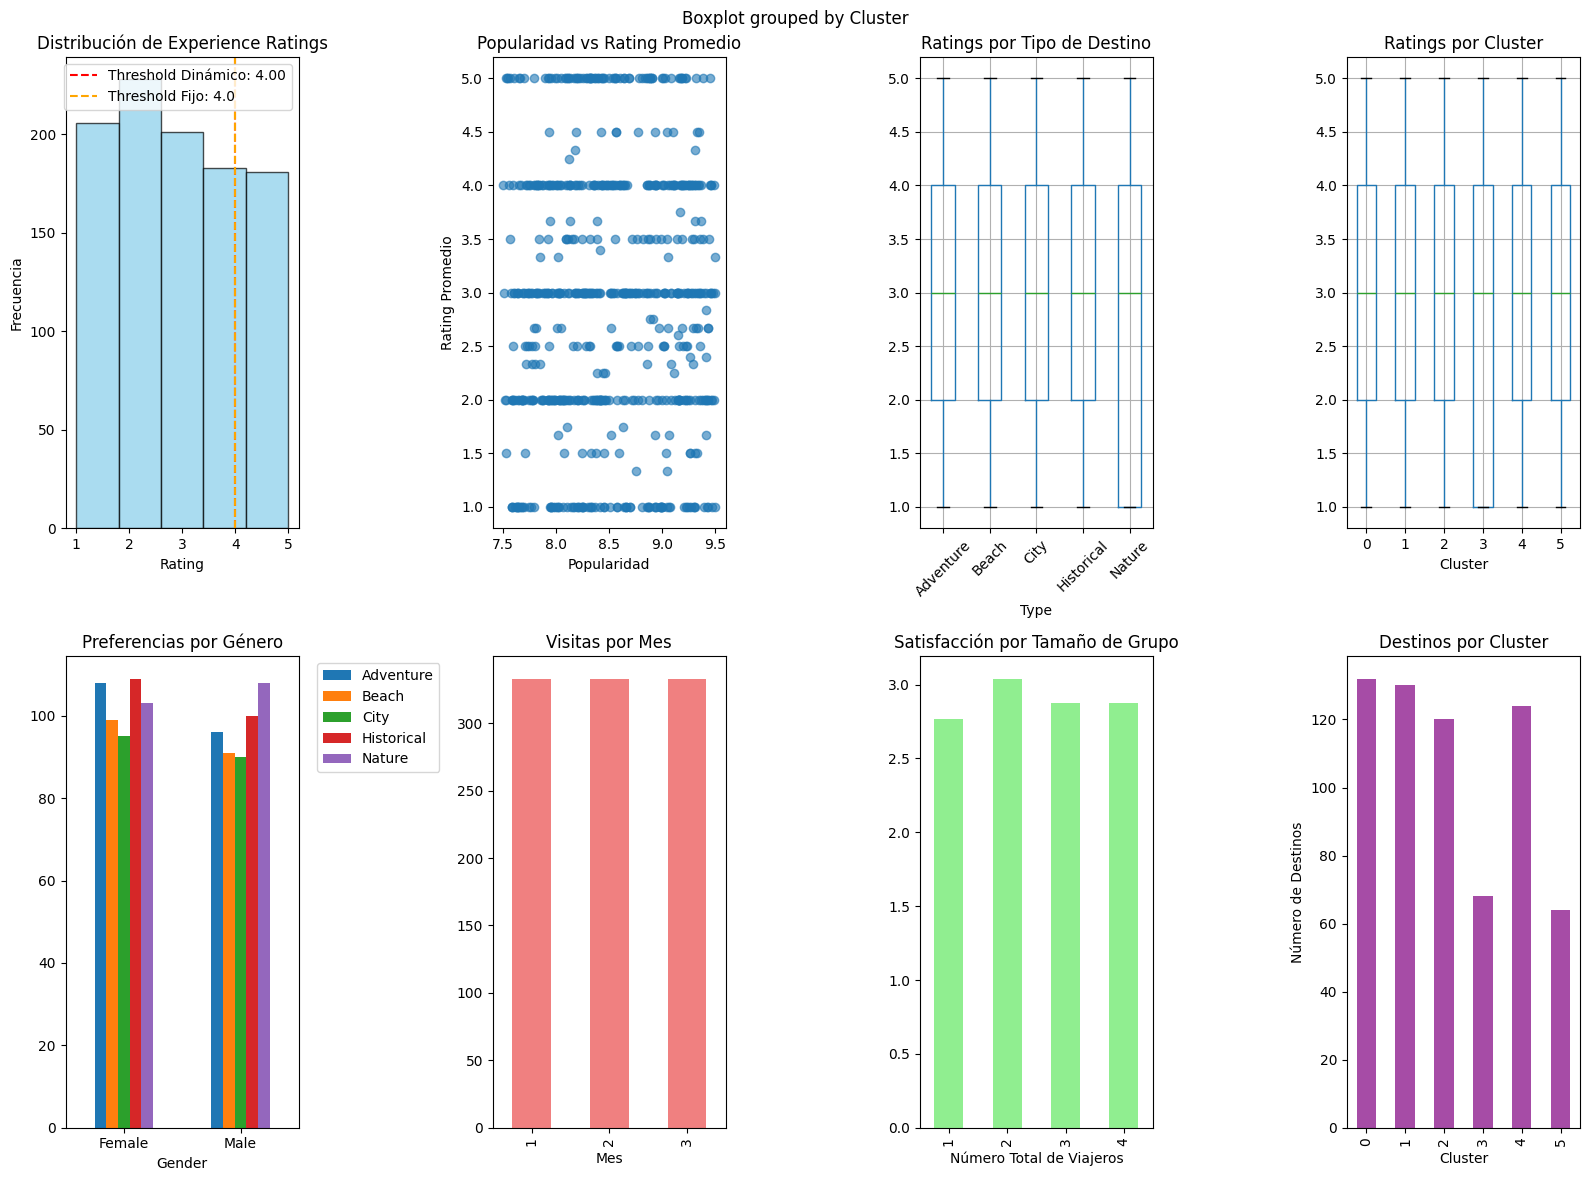

In [73]:
# ============================
# 8. VISUALIZACIONES 
# ============================

plt.figure(figsize=(16, 12))

# Distribución de ratings con threshold dinámico
plt.subplot(2, 4, 1)
plt.hist(data['ExperienceRating'], bins=5, alpha=0.7, color='skyblue', edgecolor='black')
if recommender.dynamic_threshold > 0:
    plt.axvline(recommender.dynamic_threshold, color='red', linestyle='--', label=f'Threshold Dinámico: {recommender.dynamic_threshold:.2f}')
plt.axvline(4.0, color='orange', linestyle='--', label='Threshold Fijo: 4.0')
plt.title('Distribución de Experience Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.legend()

# Popularidad vs Rating promedio
plt.subplot(2, 4, 2)
dest_stats = data.groupby('DestinationID').agg({
    'ExperienceRating': 'mean',
    'Popularity': 'mean'
})
plt.scatter(dest_stats['Popularity'], dest_stats['ExperienceRating'], alpha=0.6)
plt.title('Popularidad vs Rating Promedio')
plt.xlabel('Popularidad')
plt.ylabel('Rating Promedio')

# Ratings por tipo de destino
plt.subplot(2, 4, 3)
data.boxplot(column='ExperienceRating', by='Type', ax=plt.gca())
plt.title('Ratings por Tipo de Destino')
plt.xticks(rotation=45)

#  Análisis por clusters
plt.subplot(2, 4, 4)
cluster_ratings = data.merge(destinations_filtered[['DestinationID', 'Cluster']], on='DestinationID')
cluster_ratings.boxplot(column='ExperienceRating', by='Cluster', ax=plt.gca())
plt.title('Ratings por Cluster')
plt.xlabel('Cluster')

# Preferencias por género
plt.subplot(2, 4, 5)
gender_prefs = data.groupby(['Gender', 'Type']).size().unstack(fill_value=0)
gender_prefs.plot(kind='bar', ax=plt.gca())
plt.title('Preferencias por Género')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Actividad por mes
plt.subplot(2, 4, 6)
data['VisitDate'] = pd.to_datetime(data['VisitDate'])
data['Month'] = data['VisitDate'].dt.month
monthly_visits = data['Month'].value_counts().sort_index()
monthly_visits.plot(kind='bar', ax=plt.gca(), color='lightcoral')
plt.title('Visitas por Mes')
plt.xlabel('Mes')

# Satisfacción por grupo familiar
plt.subplot(2, 4, 7)
data['TotalTravelers'] = data['NumberOfAdults'] + data['NumberOfChildren']
family_satisfaction = data.groupby('TotalTravelers')['ExperienceRating'].mean()
family_satisfaction.plot(kind='bar', ax=plt.gca(), color='lightgreen')
plt.title('Satisfacción por Tamaño de Grupo')
plt.xlabel('Número Total de Viajeros')

#  Distribución de destinos por cluster
plt.subplot(2, 4, 8)
cluster_counts = destinations_filtered['Cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar', ax=plt.gca(), color='purple', alpha=0.7)
plt.title('Destinos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Destinos')

plt.tight_layout()
plt.savefig('travel_recommendation_analysis.png')
plt.show()